In [1]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

# from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

# from keras_applications.resnet import ResNet50

# from tensorflow.python.keras.applications.resnet50 import ResNet50
# from tensorflow.python.keras.applications import ResNet50
# from tensorflow.python.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

# from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
%cd sample2
%ls
%rm -rf /content/sample2/.ipynb_checkpoints

[Errno 2] No such file or directory: 'sample2'
/content
data_pokemon.zip  drive/  sample_data/


In [ ]:
!pwd

/content/sample2


In [ ]:
%cd ..

/content


In [4]:
!unzip data_pokemon

Archive:  data_pokemon.zip
   creating: data_pokemon/
   creating: data_pokemon/valid/
  inflating: data_pokemon/.DS_Store  
  inflating: __MACOSX/data_pokemon/._.DS_Store  
   creating: data_pokemon/test/
   creating: data_pokemon/train/
  inflating: data_pokemon/valid/.DS_Store  
  inflating: __MACOSX/data_pokemon/valid/._.DS_Store  
   creating: data_pokemon/valid/water/
   creating: data_pokemon/valid/grass/
   creating: data_pokemon/valid/fire/
  inflating: data_pokemon/test/.DS_Store  
  inflating: __MACOSX/data_pokemon/test/._.DS_Store  
   creating: data_pokemon/test/water/
   creating: data_pokemon/test/grass/
   creating: data_pokemon/test/fire/
  inflating: data_pokemon/train/.DS_Store  
  inflating: __MACOSX/data_pokemon/train/._.DS_Store  
   creating: data_pokemon/train/water/
   creating: data_pokemon/train/grass/
   creating: data_pokemon/train/fire/
  inflating: data_pokemon/valid/water/starmie.png  
  inflating: __MACOSX/data_pokemon/valid/water/._starmie.png  
  infl

In [5]:
# 資料路徑
DATASET_PATH  = '/content/data_pokemon'

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 3

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 8

# 凍結網路層數
FREEZE_LAYERS = 2

# Epoch 數
NUM_EPOCHS =  500

# 模型輸出儲存的檔案
WEIGHTS_FINAL = 'model-vgg16-final.h5'

# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False, batch_size=BATCH_SIZE)

# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
# net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
#                input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))

net = VGG16(include_top=False, weights='imagenet', input_tensor=None,
                input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))

x = net.output

from tensorflow.keras.layers import Dense, Flatten
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

Found 145 images belonging to 3 classes.
Found 49 images belonging to 3 classes.
Class #0 = fire
Class #1 = grass
Class #2 = water
58900480/58889256 [==============================] - 1s 0us/step


In [6]:
# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print("summary", net_final.summary())

# 訓練模型
history = net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE, 
                        epochs = NUM_EPOCHS)

# 儲存訓練好的模型
net_final.save(WEIGHTS_FINAL)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


summary None
Epoch 1/500


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


18/18 [==============================] - 20s 410ms/step - loss: 8.1920 - accuracy: 0.3650 - val_loss: 3.9786 - val_accuracy: 0.3333
Epoch 2/500
18/18 [==============================] - 6s 322ms/step - loss: 3.9459 - accuracy: 0.3942 - val_loss: 2.2457 - val_accuracy: 0.3958
Epoch 3/500
18/18 [==============================] - 6s 333ms/step - loss: 2.2264 - accuracy: 0.3723 - val_loss: 1.6766 - val_accuracy: 0.4167
Epoch 4/500
18/18 [==============================] - 6s 318ms/step - loss: 1.8899 - accuracy: 0.4161 - val_loss: 1.3973 - val_accuracy: 0.4583
Epoch 5/500
18/18 [==============================] - 6s 327ms/step - loss: 1.5841 - accuracy: 0.3942 - val_loss: 1.2560 - val_accuracy: 0.4792
Epoch 6/500
18/18 [==============================] - 7s 360ms/step - loss: 1.4567 - accuracy: 0.4818 - val_loss: 1.1677 - val_accuracy: 0.4792
Epoch 7/500
18/18 [==============================] - 6s 325ms/step - loss: 1.3324 - accuracy: 0.4672 - val_loss: 1.1317 - val_accuracy: 0.5000
Epoch 8/50

[0.36496350169181824, 0.39416059851646423, 0.37226277589797974, 0.41605839133262634, 0.39416059851646423, 0.48175182938575745, 0.46715328097343445, 0.41605839133262634, 0.40145984292030334, 0.4375, 0.510948896408081, 0.43795621395111084, 0.41605839133262634, 0.525547444820404, 0.43065693974494934, 0.40875911712646484, 0.44525548815727234, 0.47445255517959595, 0.5912408828735352, 0.5766423344612122, 0.540145993232727, 0.5985401272773743, 0.569343090057373, 0.5985401272773743, 0.5763888955116272, 0.5912408828735352, 0.569343090057373, 0.6131386756896973, 0.5912408828735352, 0.6277372241020203, 0.6350364685058594, 0.6788321137428284, 0.6715328693389893, 0.6944444179534912, 0.6423357725143433, 0.7080292105674744, 0.7372262477874756, 0.6934306621551514, 0.7007299065589905, 0.7956204414367676, 0.7664233446121216, 0.7372262477874756, 0.7591241002082825, 0.8102189898490906, 0.8029196858406067, 0.8175182342529297, 0.8029196858406067, 0.7956204414367676, 0.8102189898490906, 0.7664233446121216, 0

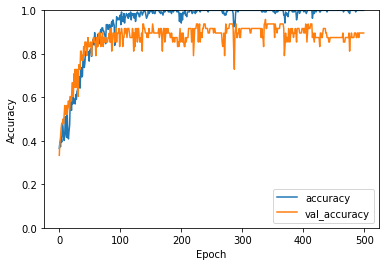

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
print(history.history['accuracy'])
print(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = net_final.evaluate(test_images,  test_labels, verbose=2)

[8.191996574401855, 3.9459314346313477, 2.2263786792755127, 1.8898533582687378, 1.5840985774993896, 1.4566755294799805, 1.332440733909607, 1.4157426357269287, 1.2336575984954834, 1.19468355178833, 1.200313687324524, 1.1482089757919312, 1.193716049194336, 1.0981377363204956, 1.0667381286621094, 1.141709327697754, 1.05319082736969, 1.016021728515625, 0.9862819314002991, 0.8689826130867004, 0.9422687888145447, 0.9330497980117798, 0.9072888493537903, 0.8707466721534729, 0.8942658305168152, 0.9797004461288452, 0.9226519465446472, 0.8693413138389587, 0.8384168148040771, 0.7994486689567566, 0.7636095881462097, 0.6914010047912598, 0.7577104568481445, 0.7184885740280151, 0.7374500632286072, 0.6857369542121887, 0.6357454657554626, 0.7289215922355652, 0.6623794436454773, 0.5441603064537048, 0.5086766481399536, 0.5618041753768921, 0.5997658371925354, 0.45066821575164795, 0.5153742432594299, 0.4412774443626404, 0.4952344000339508, 0.4741775691509247, 0.4440309703350067, 0.5174849033355713, 0.494735

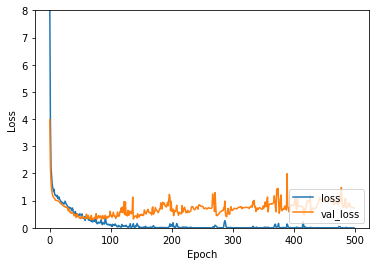

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
print(history.history['loss'])
print(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 8])
plt.legend(loc='lower right')

moltres.png


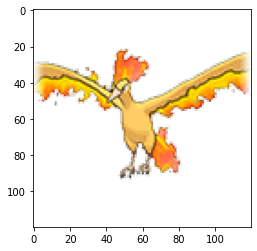

    1.000  fire
    0.000  water
    0.000  grass
numel.png


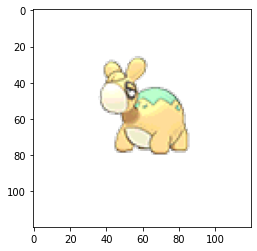

    1.000  grass
    0.000  fire
    0.000  water
oricorio-baile.jpg


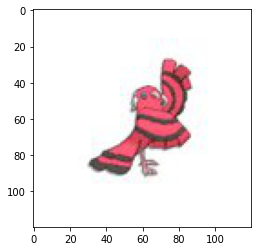

    0.854  water
    0.074  fire
    0.072  grass
ninetales.png


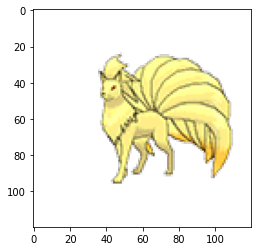

    1.000  grass
    0.000  fire
    0.000  water
monferno.png


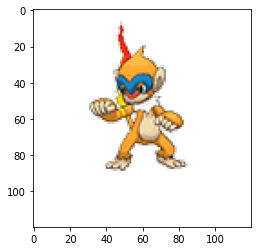

    1.000  fire
    0.000  grass
    0.000  water
pignite.png


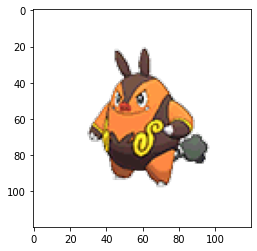

    1.000  fire
    0.000  grass
    0.000  water
pyroar.png


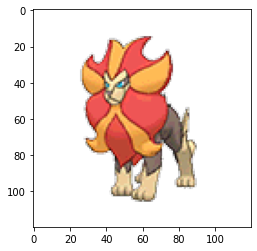

    1.000  fire
    0.000  grass
    0.000  water
simisear.png


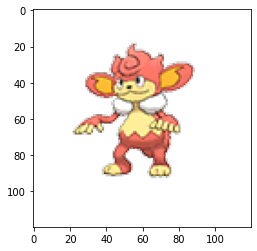

    1.000  fire
    0.000  grass
    0.000  water
pansear.png


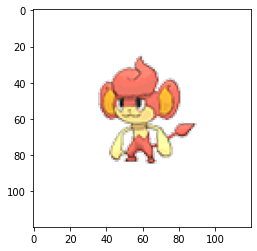

    1.000  fire
    0.000  grass
    0.000  water
rapidash.png


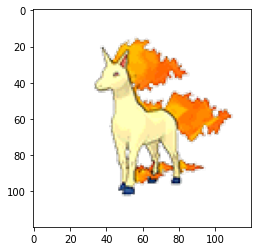

    1.000  fire
    0.000  grass
    0.000  water
ponyta.png


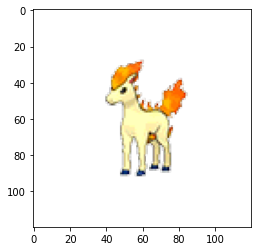

    1.000  fire
    0.000  water
    0.000  grass

fire Accuracy:  0.727


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


shellder.png


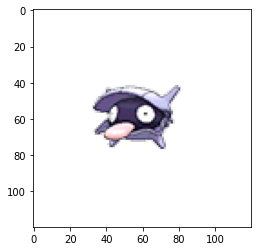

    1.000  water
    0.000  grass
    0.000  fire
poliwhirl.png


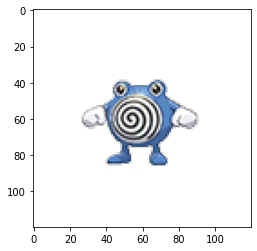

    1.000  water
    0.000  fire
    0.000  grass
qwilfish.png


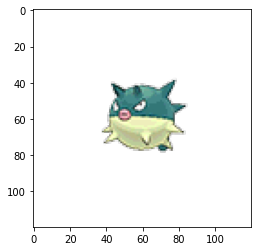

    1.000  grass
    0.000  water
    0.000  fire
sharpedo.png


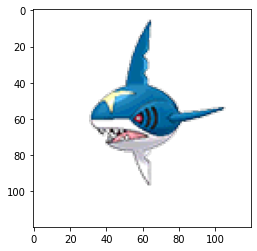

    1.000  water
    0.000  fire
    0.000  grass
primarina.jpg


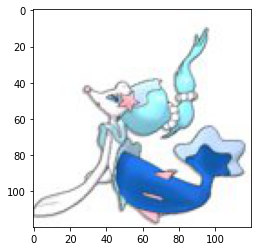

    1.000  water
    0.000  grass
    0.000  fire
seel.png


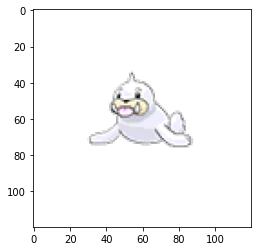

    0.988  grass
    0.012  water
    0.000  fire
piplup.png


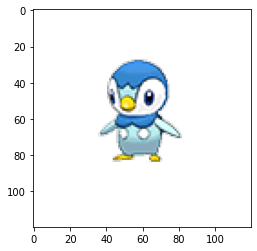

    1.000  water
    0.000  fire
    0.000  grass
poliwrath.png


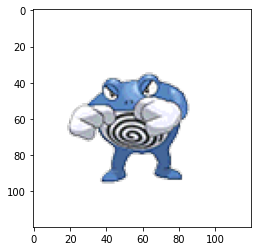

    0.999  water
    0.001  grass
    0.000  fire
remoraid.png


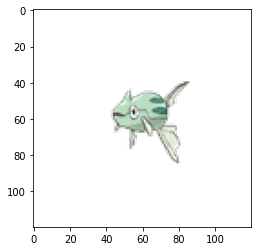

    1.000  grass
    0.000  water
    0.000  fire
shellos.png


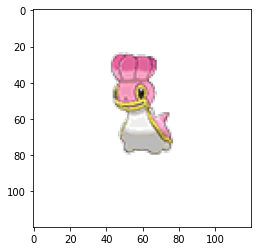

    0.996  water
    0.003  grass
    0.001  fire
samurott.png


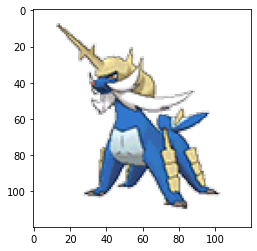

    1.000  water
    0.000  fire
    0.000  grass
quagsire.png


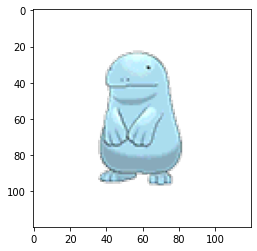

    0.992  grass
    0.008  water
    0.000  fire
simipour.png


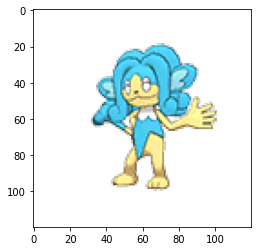

    1.000  water
    0.000  grass
    0.000  fire
poliwag.png


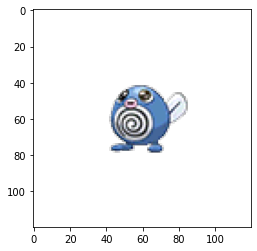

    1.000  water
    0.000  fire
    0.000  grass
relicanth.png


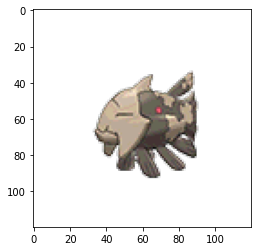

    0.734  grass
    0.266  fire
    0.000  water
seismitoad.png


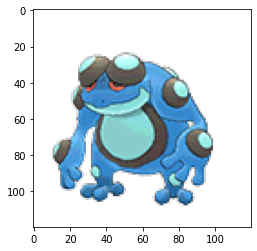

    1.000  water
    0.000  grass
    0.000  fire
pyukumuku.jpg


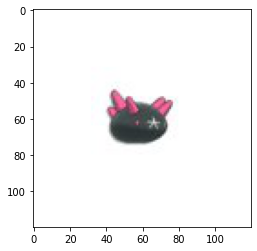

    0.863  grass
    0.096  water
    0.041  fire
seaking.png


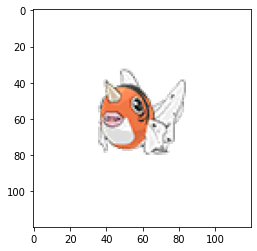

    1.000  water
    0.000  fire
    0.000  grass
psyduck.png


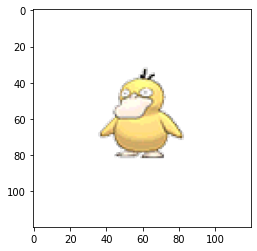

    1.000  grass
    0.000  water
    0.000  fire
prinplup.png


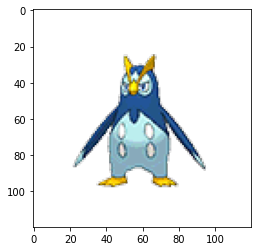

    0.622  water
    0.371  fire
    0.007  grass
popplio.jpg


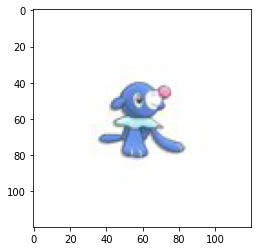

    1.000  water
    0.000  fire
    0.000  grass
seadra.png


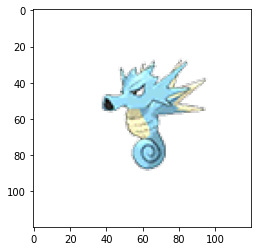

    1.000  water
    0.000  grass
    0.000  fire
politoed.png


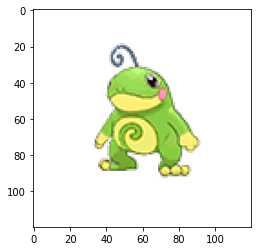

    1.000  grass
    0.000  water
    0.000  fire

water Accuracy:  0.652
whimsicott.png


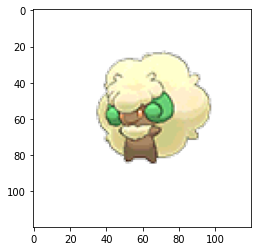

    1.000  grass
    0.000  water
    0.000  fire
virizion.png


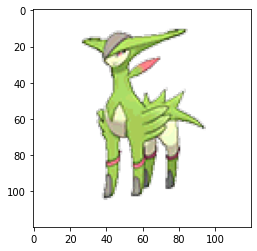

    1.000  grass
    0.000  water
    0.000  fire
vileplume.png


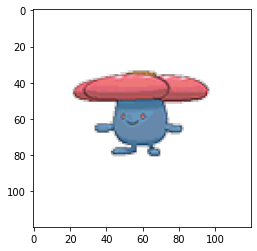

    1.000  grass
    0.000  water
    0.000  fire
tsareena.jpg


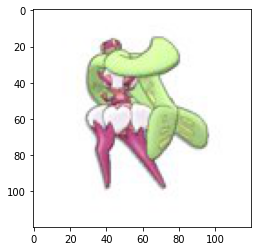

    1.000  grass
    0.000  water
    0.000  fire
treecko.png


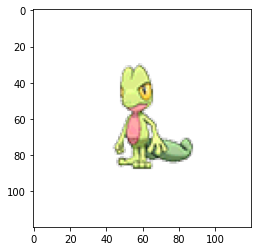

    1.000  grass
    0.000  water
    0.000  fire
tapu-bulu.jpg


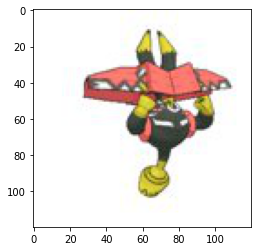

    1.000  fire
    0.000  grass
    0.000  water
weepinbell.png


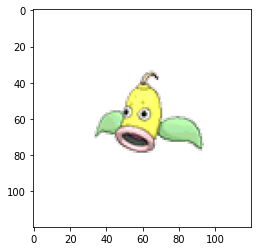

    1.000  grass
    0.000  water
    0.000  fire
torterra.png


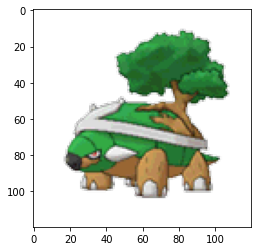

    1.000  grass
    0.000  water
    0.000  fire
tropius.png


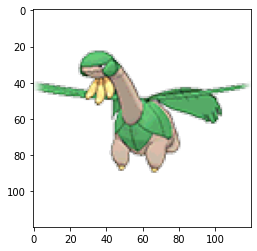

    1.000  grass
    0.000  water
    0.000  fire
venusaur.png


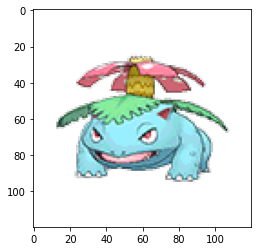

    1.000  grass
    0.000  water
    0.000  fire
turtwig.png


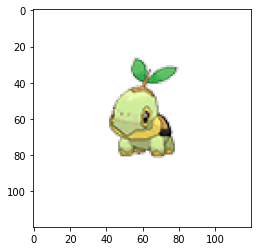

    1.000  grass
    0.000  fire
    0.000  water
tangrowth.png


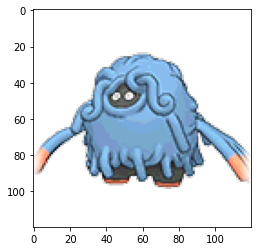

    1.000  water
    0.000  grass
    0.000  fire
tangela.png


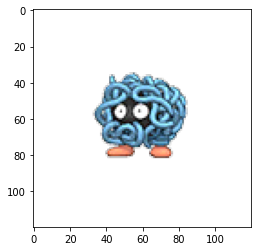

    1.000  water
    0.000  fire
    0.000  grass
sunflora.png


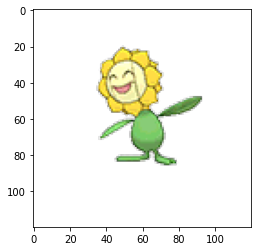

    1.000  grass
    0.000  fire
    0.000  water
victreebel.png


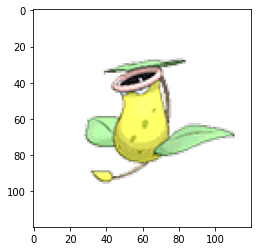

    1.000  grass
    0.000  water
    0.000  fire
sunkern.png


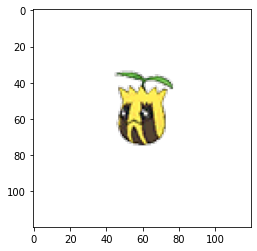

    0.986  grass
    0.014  fire
    0.000  water

grass Accuracy:  0.812


In [12]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import sys
import numpy as np
import os

def testdata(class_selected):

    # 從參數讀取圖檔路徑
    # files = sys.argv[1:]
    files = "/content/data_pokemon/test/"+ class_selected + "/"

    # 載入訓練好的模型
    net = load_model('model-vgg16-final.h5')

    cls_list = ['fire','grass', 'water']

    # 辨識每一張圖
    correct_data = 0
    all_data = 0
    for f in os.listdir(files):
    #     if f.endswith(".jpg"):
        img = image.load_img(files + f, target_size=(224, 224))
        if img is None:
            continue
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis = 0)
        pred = net.predict(x)[0]
        top_inds = pred.argsort()[::-1][:5]
        print(f)

        #print test image
        img = mpimg.imread("/content/data_pokemon/test/" + class_selected + "/" + f)
        imgplot = plt.imshow(img)
        plt.show()

        all_data = all_data + 1

        count = 0
        for i in top_inds:
            print('    {:.3f}  {}'.format(pred[i], cls_list[i]))
            if i == cls_list.index(class_selected) and count == 0:
                correct_data = correct_data + 1
            count = count + 1

    print()
    print(class_selected, "Accuracy: ",round(correct_data/all_data,3))

testdata("fire")
testdata("water")
testdata("grass")